In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
import string
import seaborn as sns
from scipy import stats
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

CATEGORICAL CHARTS

In [2]:
#Read in dataframe from Spotify Data Extraction section containing musical attributes
spotify_df = pd.read_csv('spotify_genre_df_cleaned5.csv')

In [20]:
%%capture

tknzr = TweetTokenizer()

##Use NLTK Tweet Tokenizer to attempt to tokenize contractions correctly, which were splitting using word tokenize
for i in spotify_df.index:
    try:
        spotify_df['lyrics_tokenized'][i] = tknzr.tokenize(spotify_df['lyrics'][i])
    except:
        spotify_df['lyrics_tokenized'][i] = []

In [21]:
%%capture

lemmatizer = WordNetLemmatizer()

##Change all the words in the lyrics to lowercase in order to standardize and enable named entity recognition
for i in spotify_df.index:
    spotify_df['lyrics_cleaned'][i] = [i for i in spotify_df['lyrics_tokenized'][i] if i.isalpha()]
    spotify_df['lyrics_cleaned'][i] = [i for i in spotify_df['lyrics_cleaned'][i] if not i in stopwords.words('english')]
    spotify_df['lyrics_cleaned'][i] = [lemmatizer.lemmatize(i) for i in spotify_df['lyrics_cleaned'][i]]

In [23]:
spotify_df['lyrics_cleaned_str'] = np.nan

for i in spotify_df.index:
    spotify_df['lyrics_cleaned_str'][i] = ' '.join((spotify_df.lyrics_cleaned[i]))

/Users/varunraja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/varunraja/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [35]:
%%capture
##Remove all punctuation as per list in string.punctuation EXCEPT hyphens and apostrophe's since they affect word meanings
for i in spotify_df.index:
    for t in spotify_df['lyrics_cleaned'][i][t]:
        spotify_df['lyrics_cleaned'][i][t] = re.sub("'", "", (spotify_df['lyrics_cleaned'][i][t]))

NameError: name 't' is not defined

In [31]:
spotify_df['lyrics_cleaned'][0][0]

'gettin'

Questions:
-What are the most frequent words associated with each genre?
    -Top 10 chart of each genre, word clouds
-Which genres have more overall word counts? What about unique words? How about named entities?
-What are the topics discussed in each genre? (Attempt with LDA article)

-Which genres have the highest of each attribute? (danceability, energy, loudness, speechiness, instrumentalness, liveness, valence, tempo, duration)


-How do each of the quantitative variables correlate to each other? (heatmap)

-What is the distribution of each attribute for each genre? (box plot)
-What is the correlation between each attribute and genre?

-What is the breakdown of songs per genre, artists per genre, albums per genre?
*Add column for # artists and count unique words, count before stop, most frequent word
-(Aggregate data into genre and add variance)
-How many artists per genre?

-BOX PLOT OF DISTRIBUTION OF NUMERIC VARIABLES FOR EACH GENRE
-VARIABLES AGAINST COUNT OF GENRE
-HEATMAP OF CORRELATION BETWEEN NUMERICAL VARIABLES, ANOVA TEST FOR NUM/CAT
-HISTOGRAM OF DISTRUBUTIONS OF NUMERICAL VARIABLES
-PIE CHARTS OR STACKED BAR GRAPHS OF CATEGORICAL VARIABLES DISTRIBUTION

In [234]:
spotify_df.lyrics_cleaned.iloc[0]

"['gettin', 'born', 'state', 'mississippi', 'poppa', 'copper', 'momma', 'hippie', 'alabama', 'would', 'swing', 'hammer', 'price', 'gotta', 'pay', 'break', 'panorama', 'never', 'knew', 'anything', 'poor', 'world', 'company', 'take', 'black', 'bandana', 'sweet', 'louisiana', 'robbin', 'bank', 'state', 'indiana', 'runner', 'rebel', 'stunner', 'merry', 'way', 'sayin', 'baby', 'gonna', 'lookin', 'barrel', 'hot', 'metal', 'another', 'way', 'survive', 'california', 'rest', 'peace', 'simultaneous', 'release', 'california', 'show', 'teeth', 'priestess', 'priest', 'yeah', 'yeah', 'lover', 'baby', 'fighter', 'shoulda', 'seen', 'comin', 'got', 'little', 'brighter', 'name', 'like', 'dani', 'california', 'day', 'gonna', 'come', 'gonna', 'mourn', 'ya', 'little', 'loaded', 'stealin', 'another', 'breath', 'love', 'baby', 'death', 'california', 'rest', 'peace', 'simultaneous', 'release', 'california', 'show', 'teeth', 'priestess', 'priest', 'yeah', 'yeah', 'knew', 'side', 'knew', 'others', 'died', 'prov

In [81]:
spotify_df_agg

,playlist_name,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,duration_ms,time_signature,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,entity_count_unique,count_artist,count_track,count_album
0,Country,0.5715,0.6695,-6.3630,0.0335,0.000001,0.1235,0.519,124.9930,3.531117,211867.0,4.0,274.0,125.0,107.0,65.0,5.0,200.0,1708.0,756.0
1,Electronic/Dance,0.6160,0.8380,-4.8665,0.0594,0.012300,0.1525,0.325,127.9875,3.627825,217669.5,4.0,153.0,69.0,38.0,20.0,0.0,362.0,1747.0,1471.0
2,Hip-Hop,0.7590,0.6230,-6.7195,0.2295,0.000000,0.1350,0.445,121.0750,3.297925,197875.5,4.0,493.0,244.0,175.0,121.0,11.0,220.0,1798.0,752.0
3,Pop,0.6435,0.6240,-6.0205,0.0515,0.000000,0.1180,0.466,118.8915,3.479333,208760.0,4.0,337.0,156.0,102.0,62.0,4.0,437.0,1762.0,1168.0
4,Rock,0.4920,0.7680,-5.8910,0.0412,0.000094,0.1250,0.401,124.0260,3.948950,236937.0,4.0,248.0,115.0,84.0,51.0,2.0,322.0,1793.0,967.0


In [34]:
spotify_df.describe()

,Unnamed: 0,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,duration_ms,time_signature,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,entity_count_unique,count_artist,count_track,count_album
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,4999.50000,0.606127,0.681767,-6.407974,0.100645,0.064241,0.194992,0.451779,123.758013,3.728424,223705.434300,3.947800,292.016400,143.36170,101.580400,66.933000,7.426000,308.200000,1761.600000,1022.80000
std,2886.89568,0.151107,0.193031,2.745441,0.108305,0.190840,0.156917,0.226044,29.042635,1.016910,61014.595684,0.302464,189.120885,101.91238,72.126808,55.220248,11.673352,88.503917,32.856475,271.89401
min,0.00000,0.061700,0.016700,-26.967000,0.022600,0.000000,0.014100,0.025800,43.509000,0.646000,38760.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,200.000000,1708.000000,752.00000
25%,2499.75000,0.506000,0.551000,-7.762250,0.035300,0.000000,0.097600,0.272000,99.992500,3.124825,187489.500000,4.000000,179.000000,81.00000,60.000000,34.000000,0.000000,220.000000,1747.000000,756.00000
50%,4999.50000,0.605000,0.705000,-5.962500,0.051000,0.000005,0.128000,0.433000,124.988500,3.579083,214745.000000,4.000000,281.000000,130.00000,96.000000,58.000000,3.000000,322.000000,1762.000000,967.00000
75%,7499.25000,0.713000,0.837000,-4.573750,0.111000,0.001480,0.253000,0.617250,143.994500,4.149838,248990.250000,4.000000,392.000000,191.00000,131.000000,85.000000,10.000000,362.000000,1793.000000,1168.00000
max,9999.00000,0.981000,0.999000,0.878000,0.944000,0.989000,0.982000,0.978000,208.951000,15.725483,943529.000000,5.000000,825.000000,766.00000,574.000000,563.000000,153.000000,437.000000,1798.000000,1471.00000


In [29]:
%%capture

genres = ['Rock', 'Country', 'Hip-Hop', 'Pop', 'Electronic/Dance']
spotify_df['count_artist'] = np.nan
spotify_df['count_track'] = np.nan
spotify_df['count_album'] = np.nan

for genre in genres:
    for i in spotify_df[spotify_df['playlist_name'] == genre].index:  
        spotify_df['count_artist'][i] = spotify_df[spotify_df['playlist_name'] == genre]['artist'].nunique()
        spotify_df['count_track'][i] = spotify_df[spotify_df['playlist_name'] == genre]['track_name'].nunique()
        spotify_df['count_album'][i] = spotify_df[spotify_df['playlist_name'] == genre]['album'].nunique()

In [32]:
spotify_df.columns

Index(['track_name', 'artist', 'album', 'track_id', 'playlist_name',
       'danceability', 'energy', 'full_key', 'key', 'mode', 'loudness',
       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_minutes', 'duration_ms', 'time_signature', 'lyrics',
       'lyrics_tokenized', 'word_count', 'lyrics_cleaned', 'named_entities',
       'word_count_cleaned', 'word_count_unique', 'word_count_cleaned_unique',
       'entity_count_unique', 'count_artist', 'count_track', 'count_album'],
      dtype='object')

In [75]:
spotify_df.groupby(['playlist_name'], as_index=False).aggregate('mean')

,playlist_name,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,duration_ms,time_signature,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,entity_count_unique,count_artist,count_track,count_album
0,Country,0.568432,0.633098,-7.124778,0.041482,0.004473,0.185550,0.529803,124.242878,3.612148,216728.8555,3.9240,267.1760,123.7305,105.2605,65.9540,6.5570,200.0,1708.0,756.0
1,Electronic/Dance,0.609902,0.808250,-5.083547,0.096379,0.210112,0.218809,0.355264,128.585491,3.821456,229287.3735,3.9645,172.4835,84.9365,51.9545,32.6735,3.8260,362.0,1747.0,1471.0
2,Hip-Hop,0.738308,0.624119,-6.901738,0.229157,0.005786,0.207348,0.459637,120.699137,3.467361,208041.6530,3.9840,436.9815,221.1660,159.8355,113.1015,13.2165,220.0,1798.0,752.0
3,Pop,0.631118,0.612103,-6.465645,0.080024,0.012772,0.168975,0.484786,120.708340,3.544961,212697.6750,3.9320,331.3630,165.9530,105.0340,69.2630,8.8695,437.0,1762.0,1168.0
4,Rock,0.482873,0.731268,-6.464162,0.056185,0.088063,0.194278,0.429403,124.554217,4.196194,251771.6145,3.9345,252.0780,121.0225,85.8175,53.6730,4.6610,322.0,1793.0,967.0


In [39]:
spotify_df_agg = spotify_df.groupby(['playlist_name'], as_index=False).aggregate('median')

In [37]:
numerical_variables = ['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'liveness', 
                       'valence', 'tempo', 'duration_minutes', 'word_count', 'word_count_cleaned', 'word_count_unique',
                       'word_count_cleaned_unique', 'entity_count_unique']

fixed_variables = ['count_artist', 'count_track', 'count_album']

categorical_variables = ['playlist_name', 'full_key', 'key', 'mode', 'lyrics', 'lyrics_tokenized', 
                         'lyrics_cleaned', 'named_entities']

target_variable = 'playlist_name'

In [39]:
spotify_df[numerical_variables].head(5)

,danceability,energy,loudness,speechiness,instrumentalness,liveness,valence,tempo,duration_minutes,word_count,word_count_cleaned,word_count_unique,word_count_cleaned_unique,count_artist,count_track,count_album
0,0.556,0.913,-2.360,0.0437,0.000009,0.346,0.730,96.184,4.702667,306.0,161.0,144.0,105.0,322.0,1793.0,967.0
1,0.592,0.767,-2.788,0.0270,0.001650,0.127,0.328,96.483,5.495550,286.0,154.0,151.0,98.0,322.0,1793.0,967.0
2,0.433,0.959,-4.040,0.0431,0.000000,0.028,0.365,172.984,4.489550,461.0,174.0,106.0,66.0,322.0,1793.0,967.0
3,0.502,0.912,-4.556,0.0564,0.000173,0.106,0.720,116.761,5.032000,249.0,138.0,85.0,48.0,322.0,1793.0,967.0
4,0.595,0.717,-4.803,0.0295,0.002740,0.108,0.547,88.969,3.598450,248.0,115.0,79.0,49.0,322.0,1793.0,967.0


In [45]:
spotify_df[categorical_variables].head(5)

,playlist_name,full_key,key,mode,lyrics,lyrics_tokenized,lyrics_cleaned,named_entities
0,Rock,C Major,C,Major,gettin' born in the state of mississippi po...,"['gettin', ""'"", 'born', 'in', 'the', 'state', ...","['gettin', 'born', 'state', 'mississippi', 'po...","[mississippi poppa, alabama, sweet louisiana r..."
1,Rock,A Minor,A,Minor,psychic spies from china try to steal your mi...,"['psychic', 'spies', 'from', 'china', 'try', '...","['psychic', 'spy', 'china', 'try', 'steal', 'e...","(china, sweden, east, hollywood, hollywood, al..."
2,Rock,A Major,A,Major,keep you in the dark you know they all preten...,"['keep', 'you', 'in', 'the', 'dark', 'you', 'k...","['keep', 'dark', 'know', 'pretend', 'keep', 'd...",()
3,Rock,C# Major,C#,Major,load up on guns bring your friends it's fun t...,"['load', 'up', 'on', 'guns', 'bring', 'your', ...","['load', 'gun', 'bring', 'friend', 'fun', 'los...",()
4,Rock,C Major,C,Major,scar tissue that i wish you saw sarcastic mis...,"['scar', 'tissue', 'that', 'i', 'wish', 'you',...","['scar', 'tissue', 'wish', 'saw', 'sarcastic',...","(kentucky, fallin, ma, pa, viewin, autumn)"


In [44]:
sns.barplot(data=spotify_df, x='full_key')

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
genres = ['Rock', 'Pop', 'Hip-Hop', 'Country', 'Electronic/Dance']

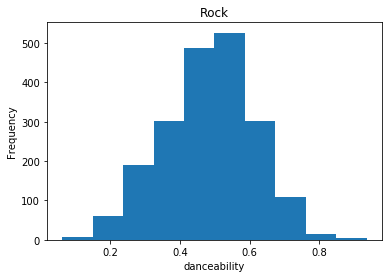

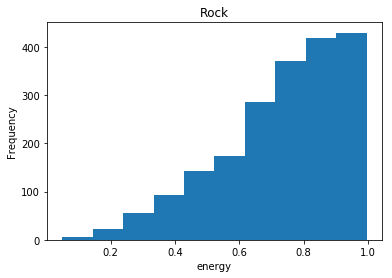

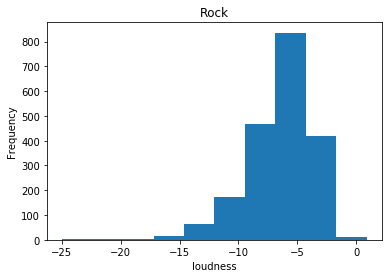

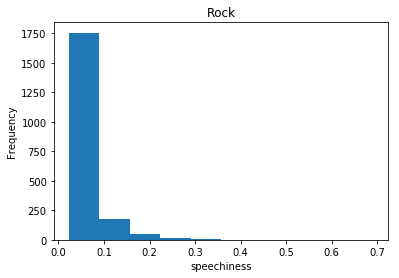

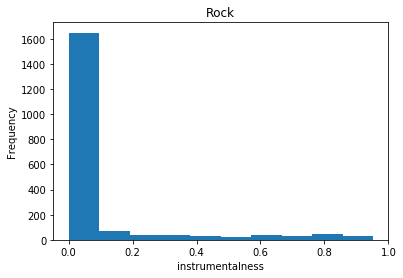

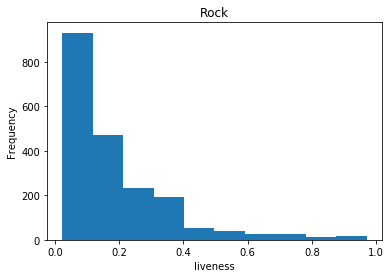

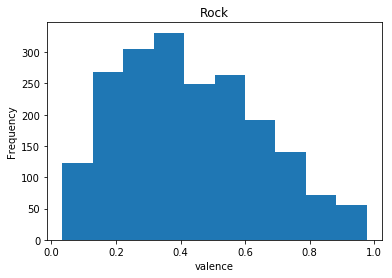

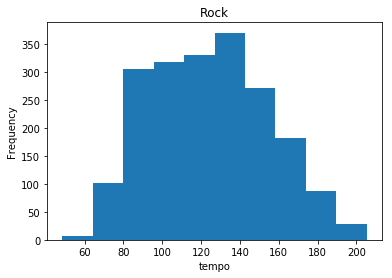

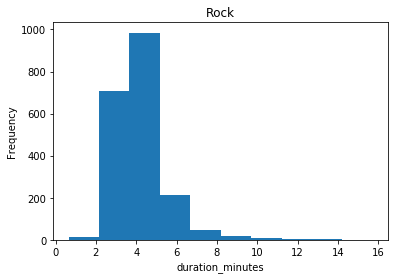

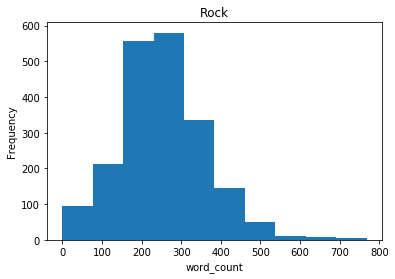

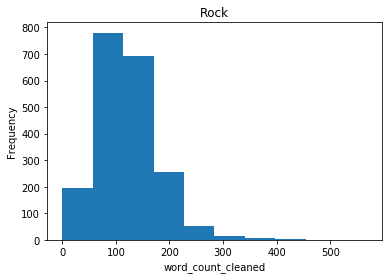

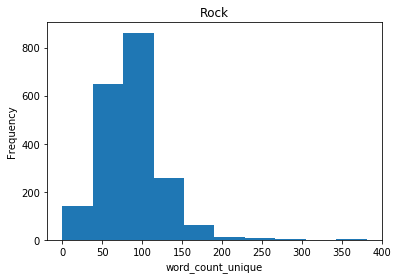

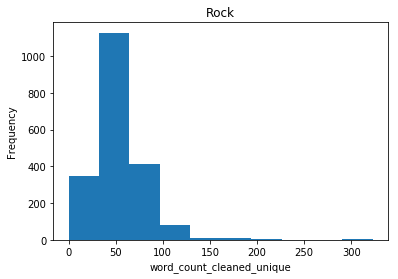

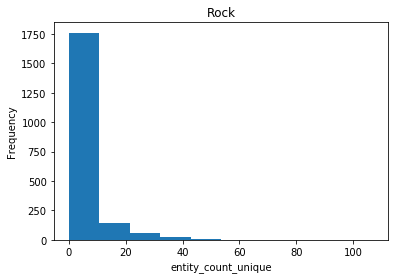

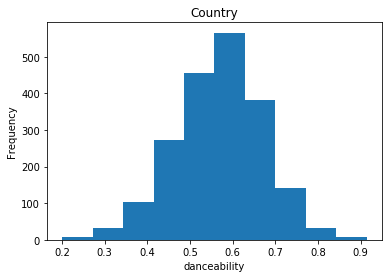

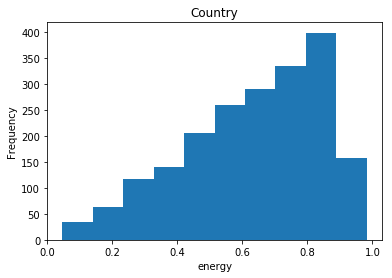

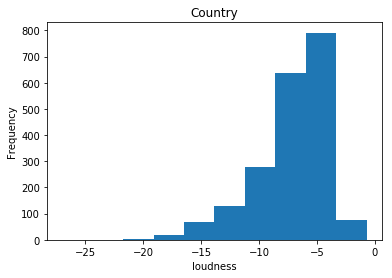

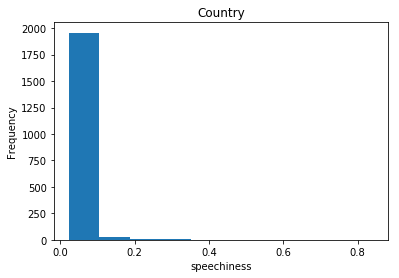

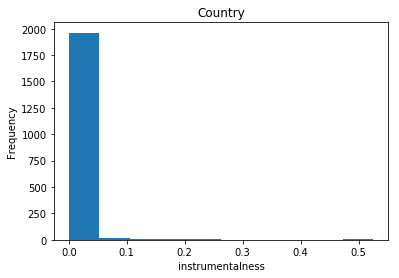

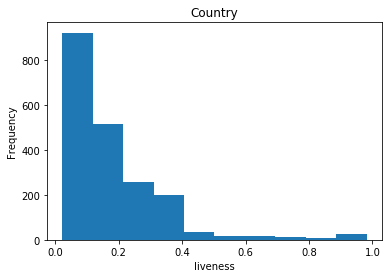

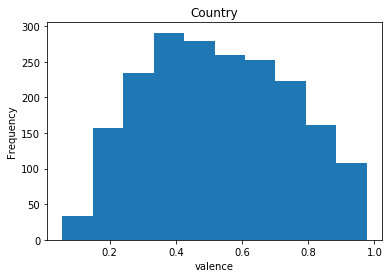

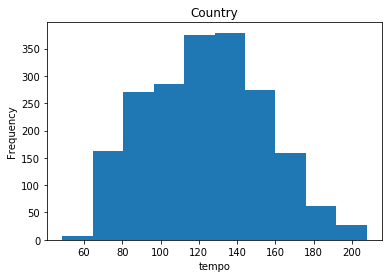

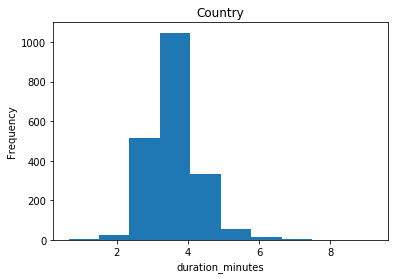

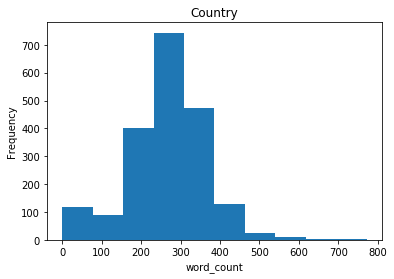

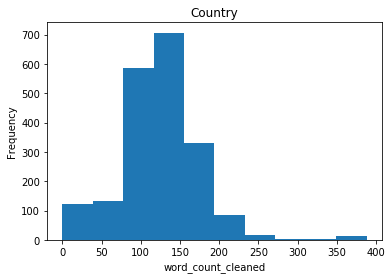

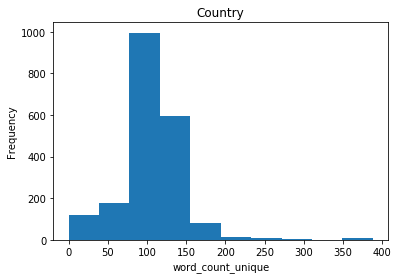

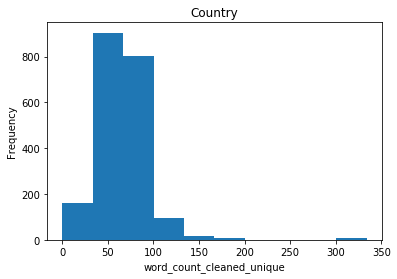

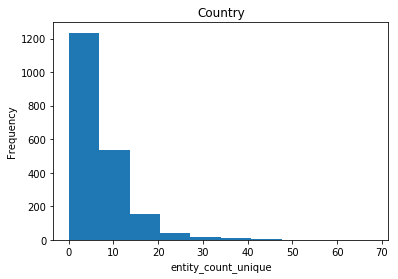

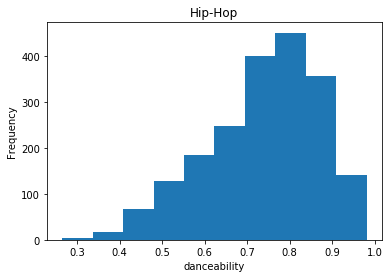

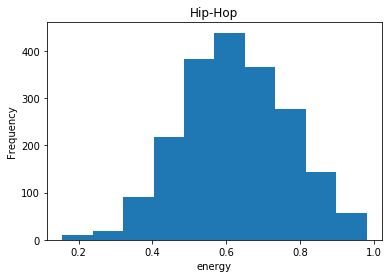

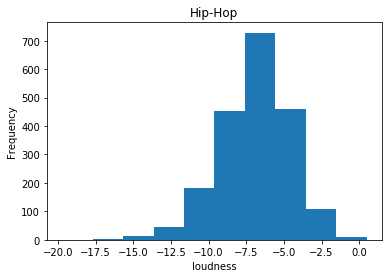

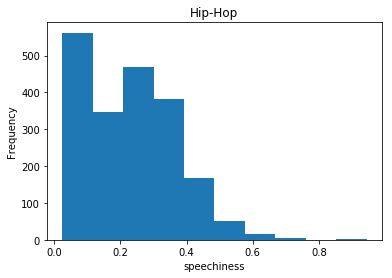

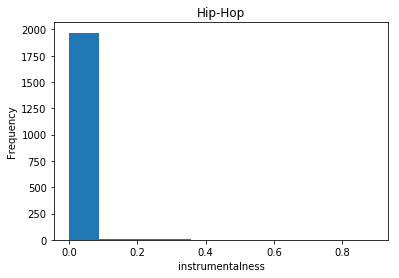

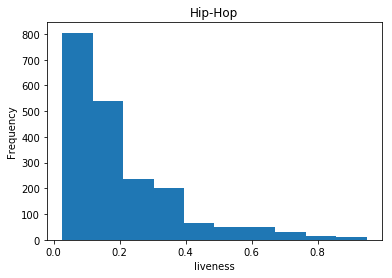

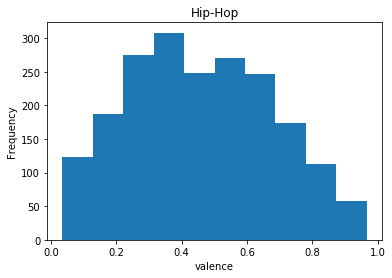

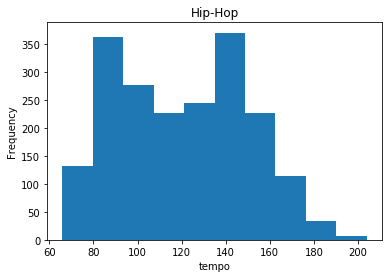

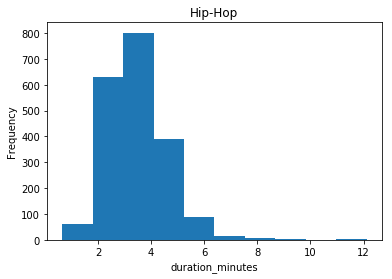

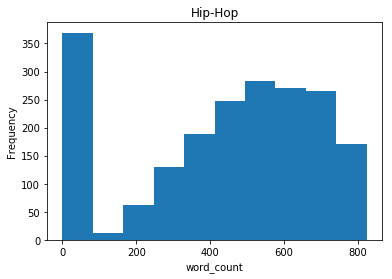

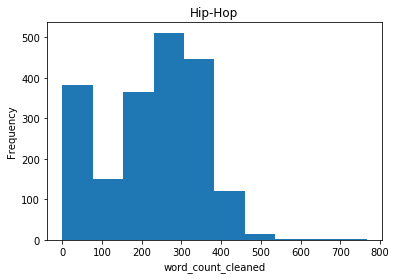

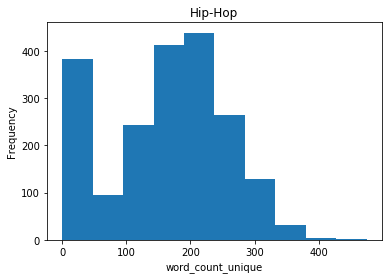

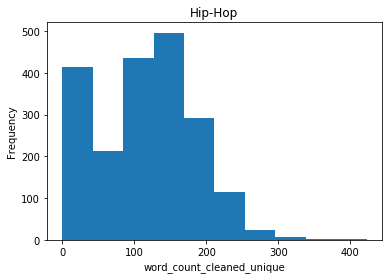

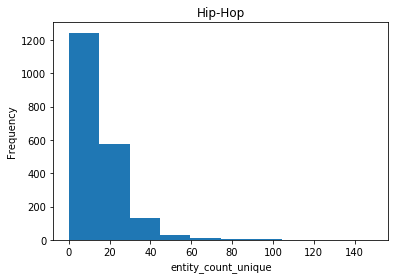

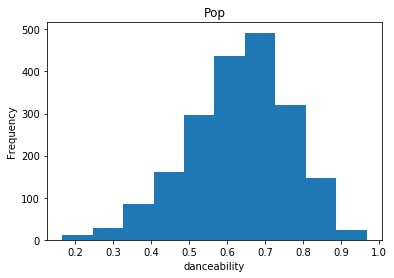

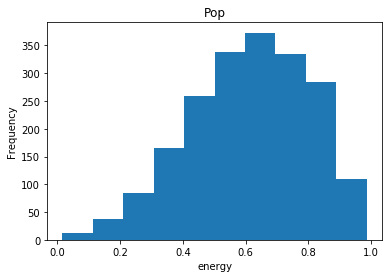

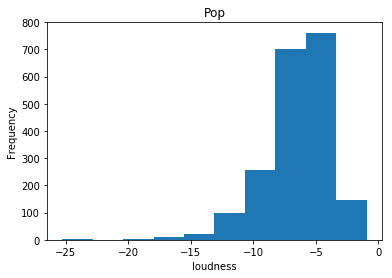

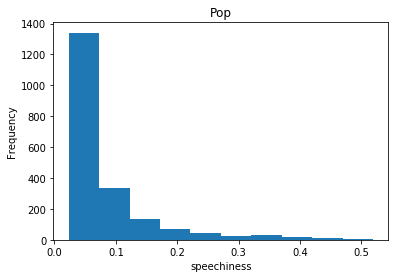

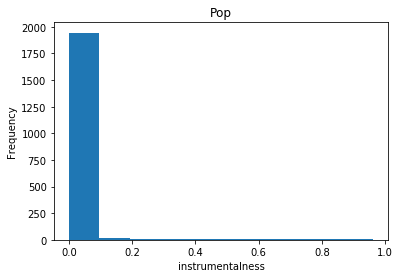

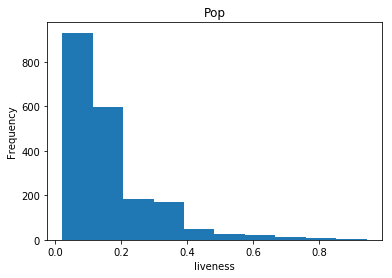

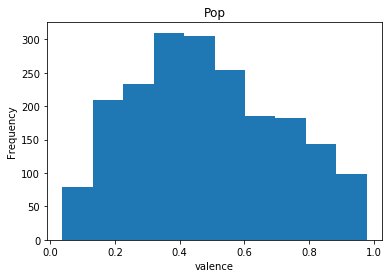

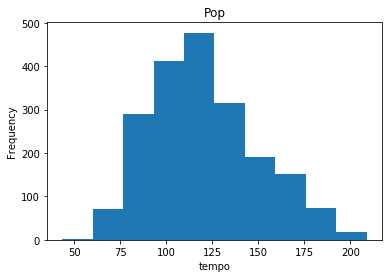

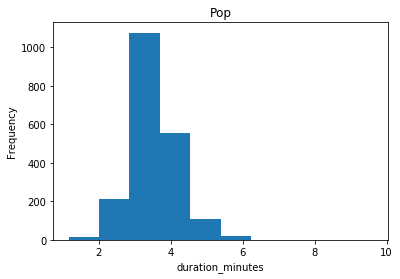

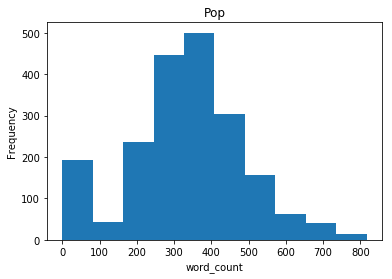

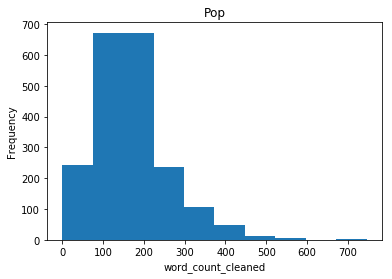

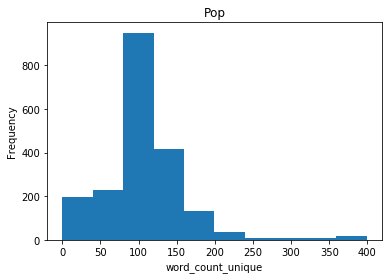

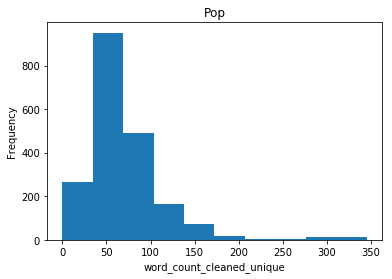

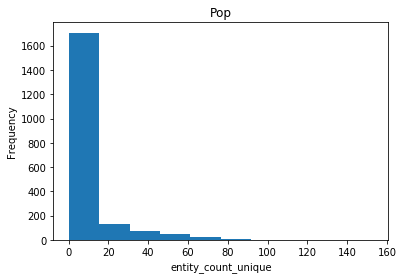

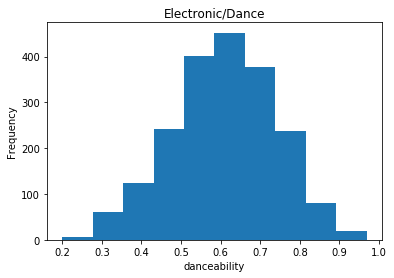

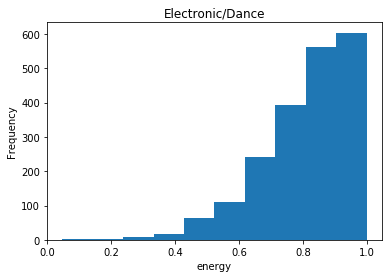

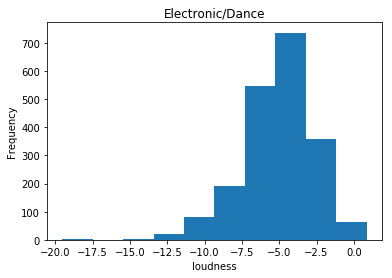

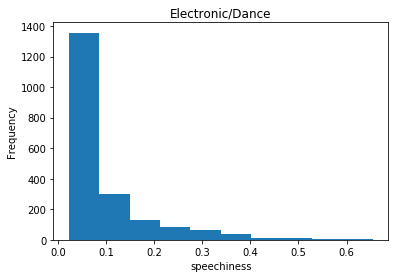

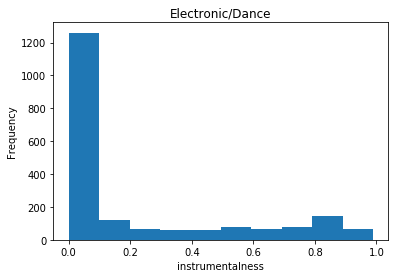

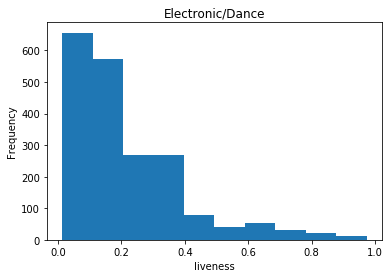

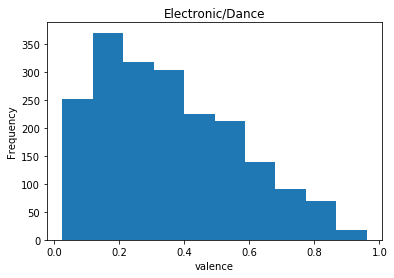

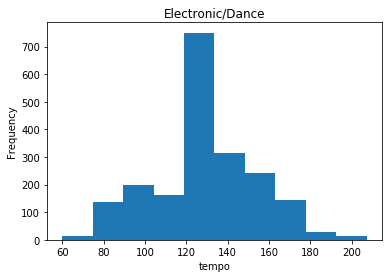

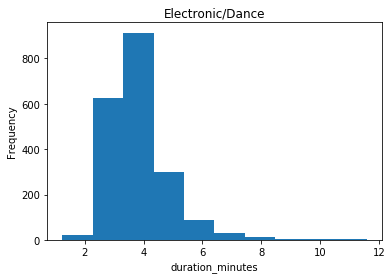

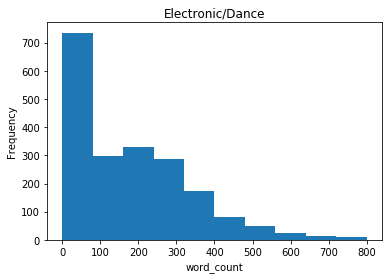

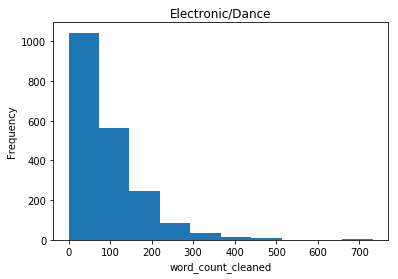

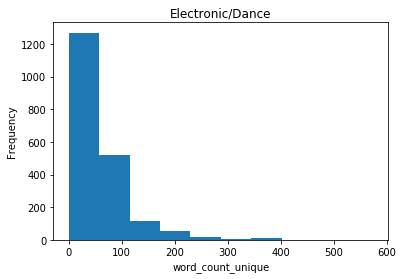

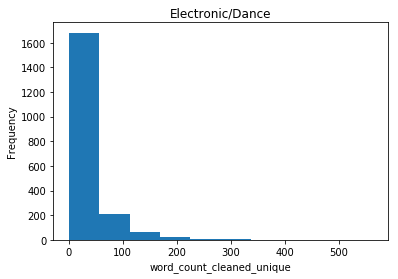

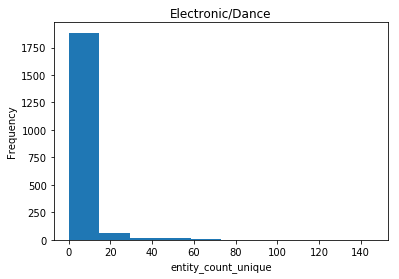

In [62]:
for genre in genres:
    for feature in numerical_variables:
        spotify_df[spotify_df['playlist_name'] == genre][feature].plot.hist()    
        plt.xlabel(feature)
        plt.title(genre)
        plt.show()    

In [ ]:
spotify_df[]

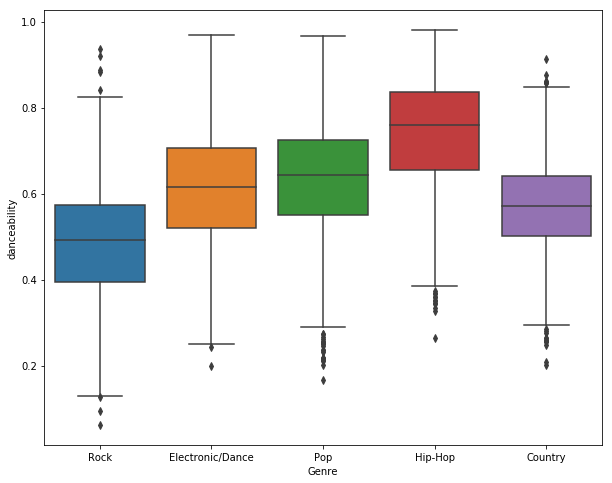

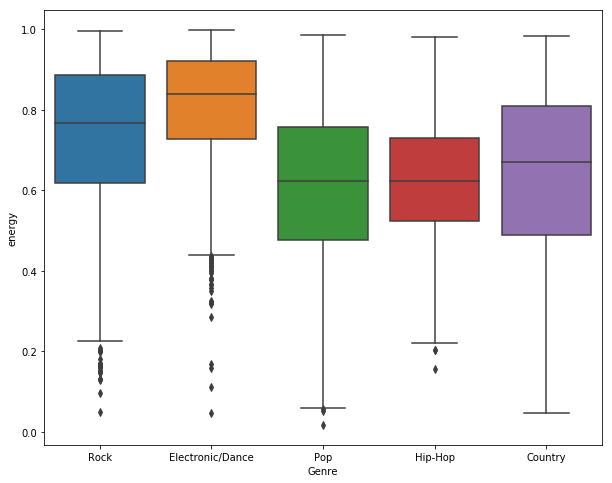

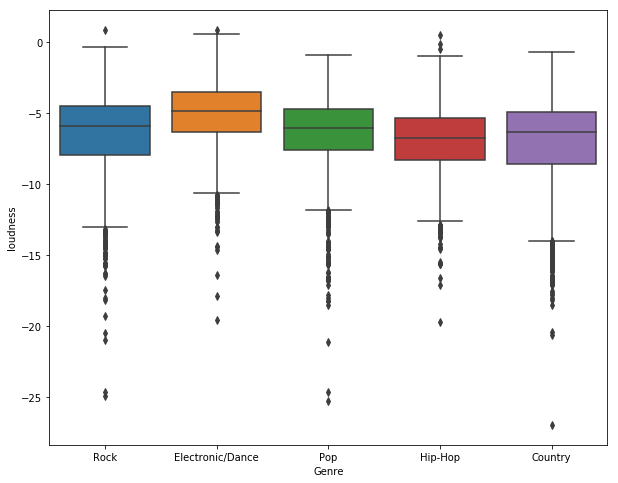

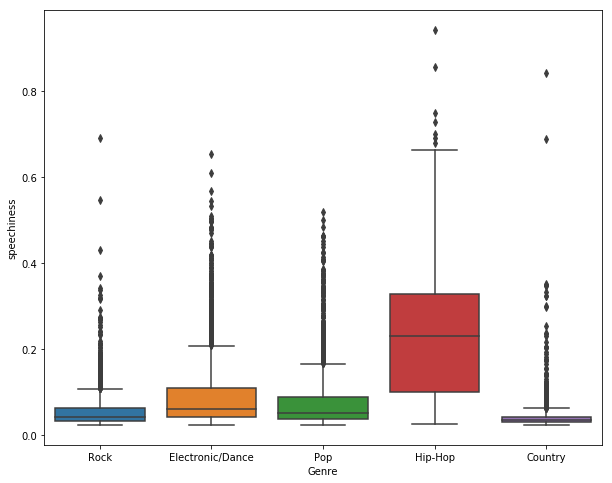

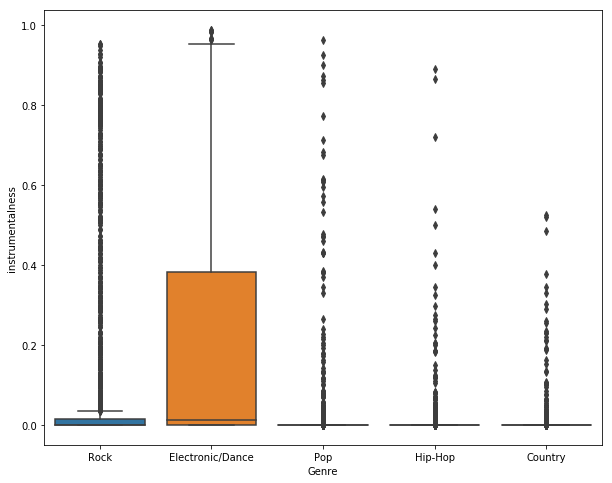

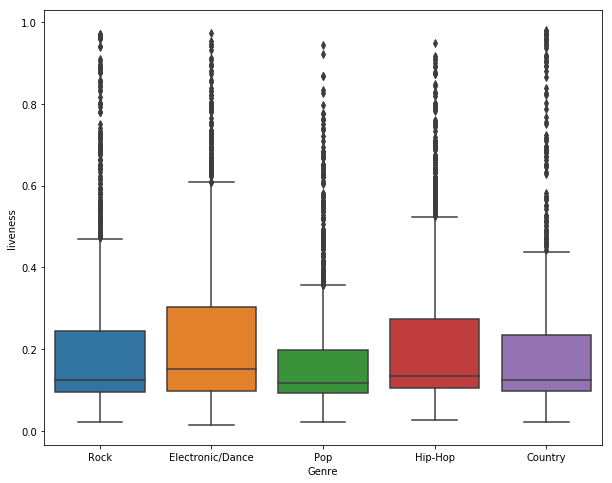

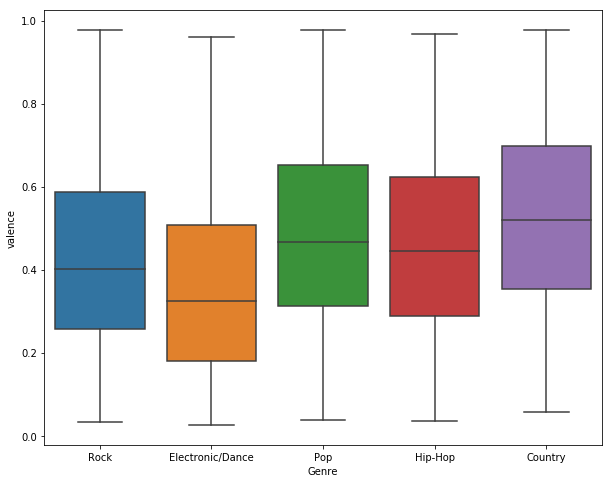

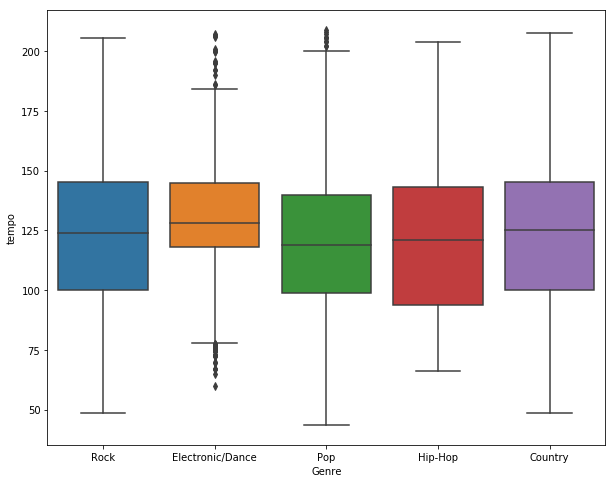

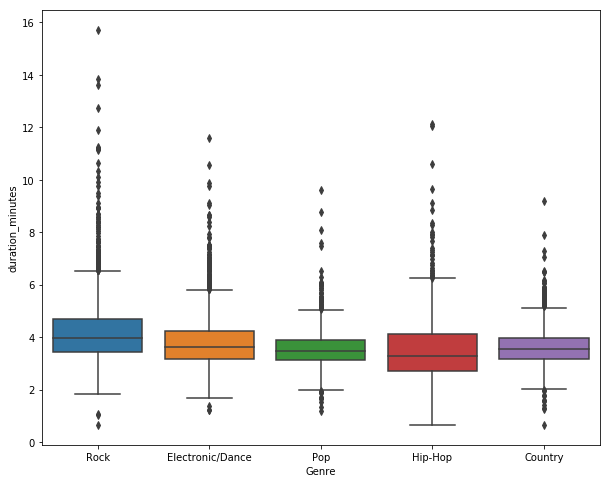

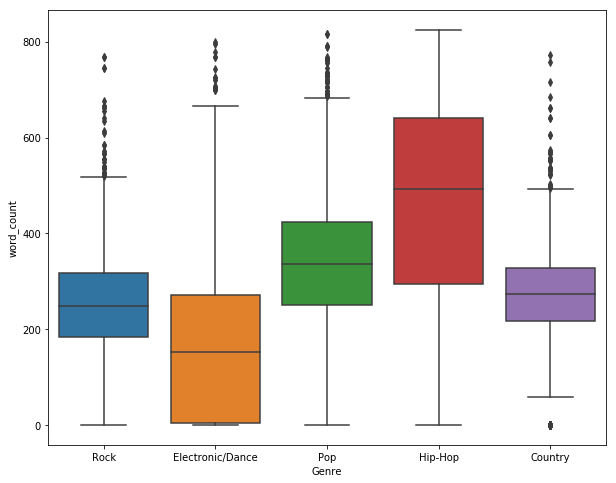

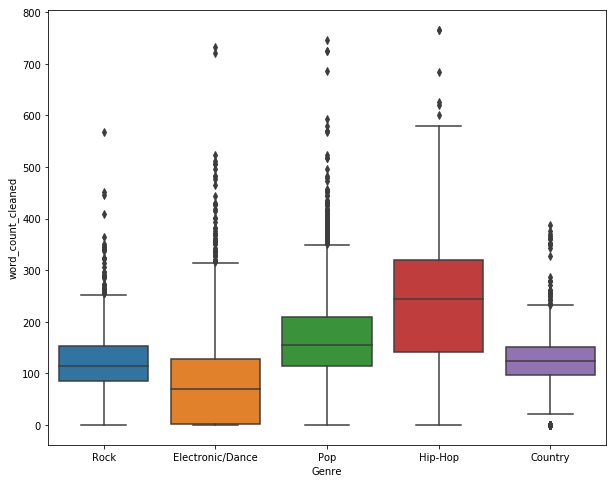

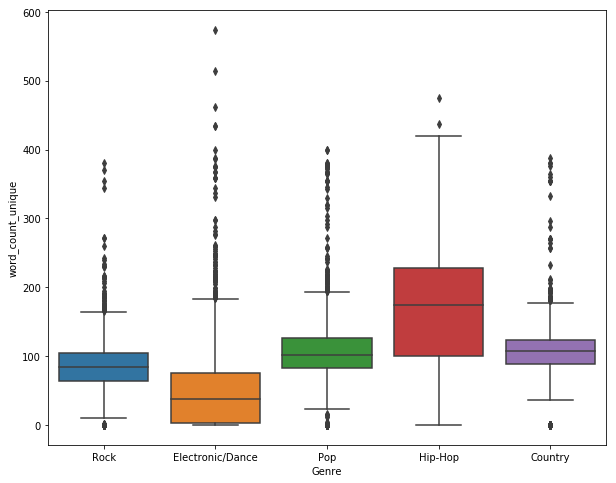

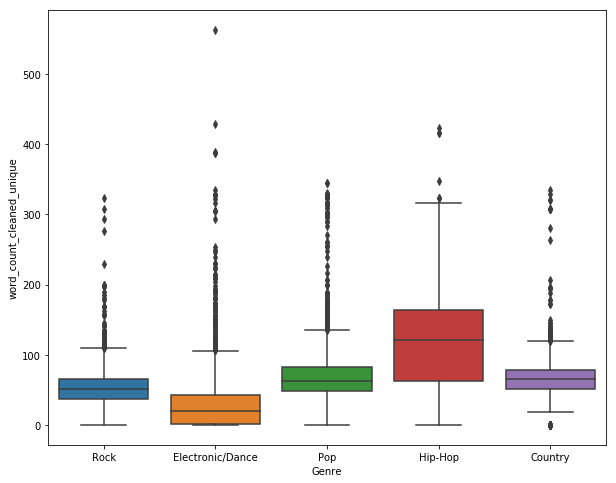

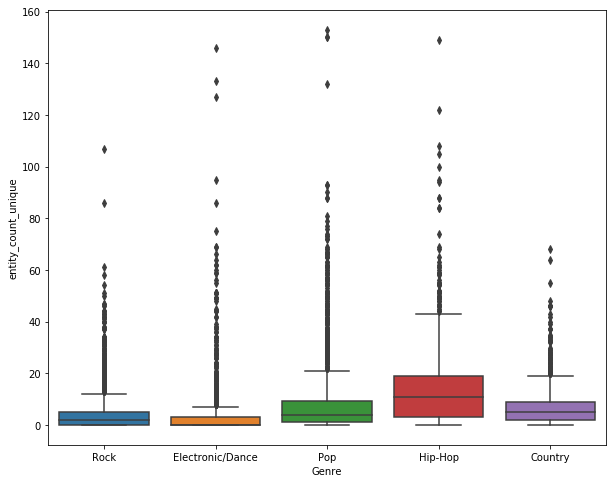

In [73]:
for feature in numerical_variables:
    sns.boxplot(data=spotify_df, x='playlist_name', y=feature)
    #sns.swarmplot(data=spotify_df.head(2001), x='playlist_name', y=feature, size=10)
    plt.xlabel('Genre')
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.show()    

#spotify_df[spotify_df['playlist_name'] == 'Rock']['word_count'].plot.hist()
#plt.show()

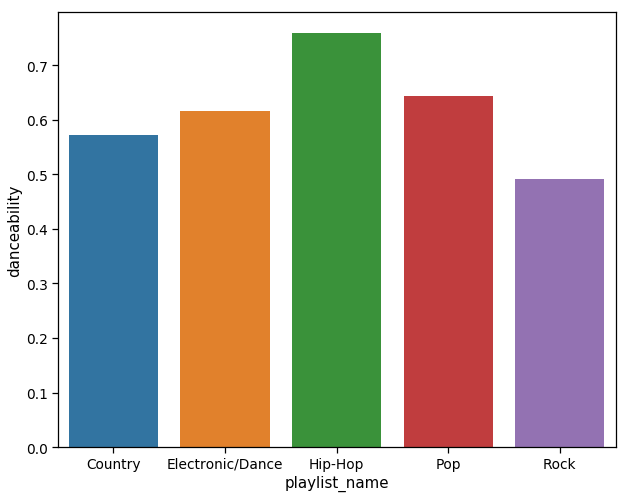

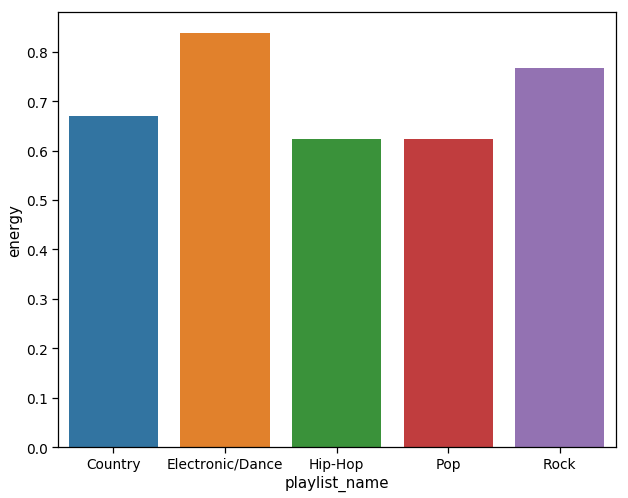

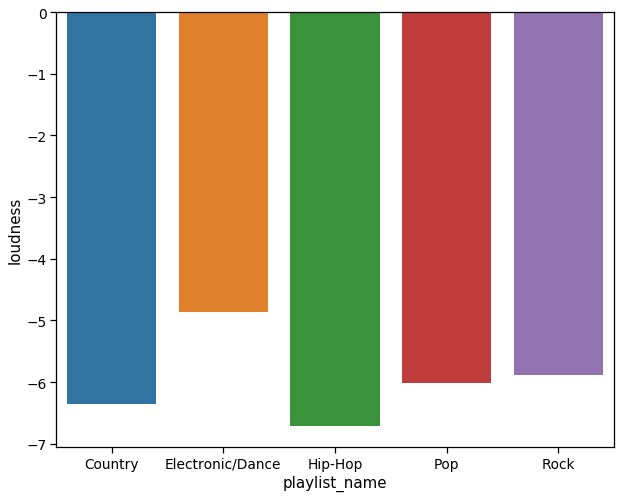

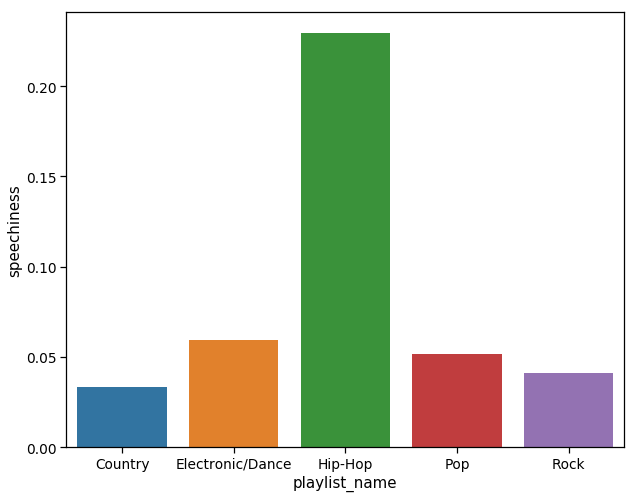

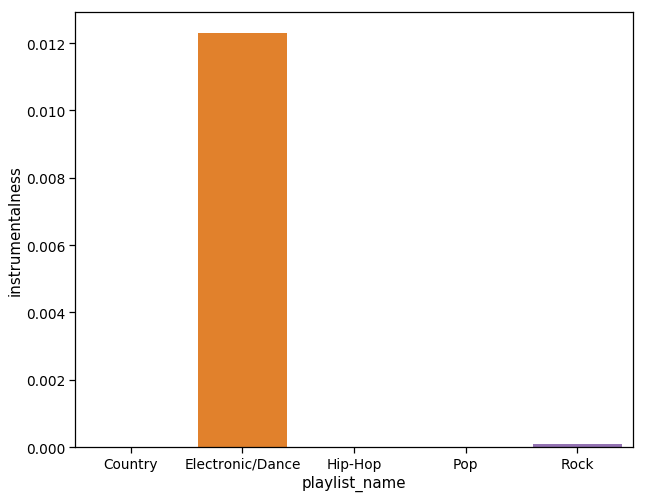

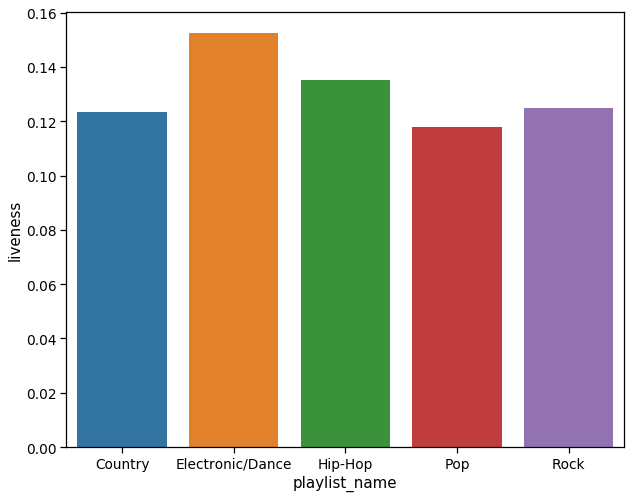

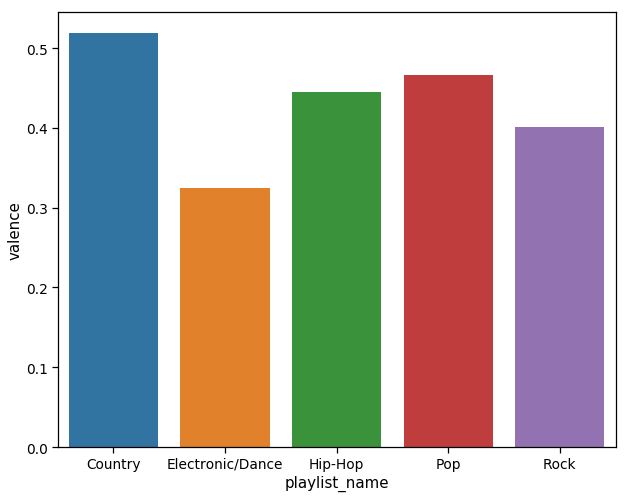

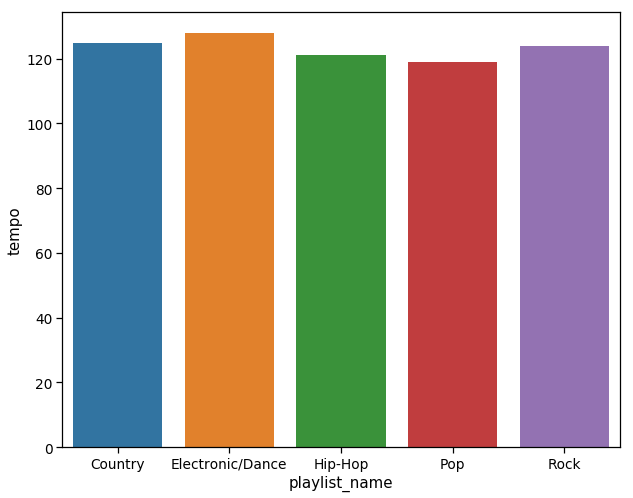

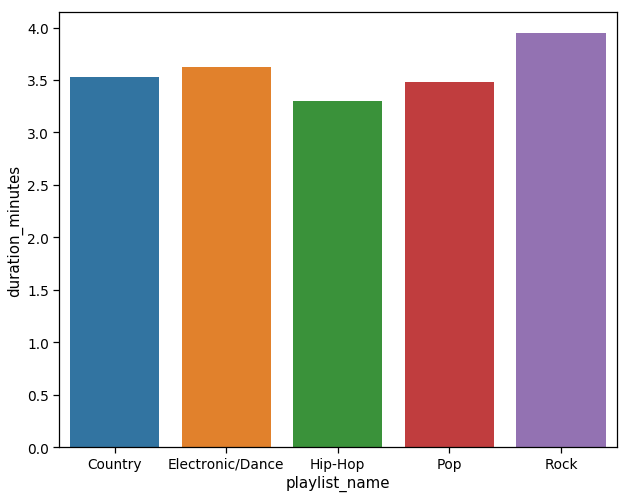

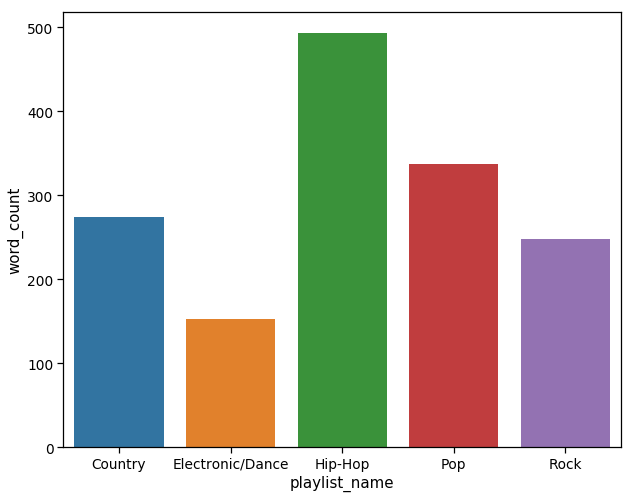

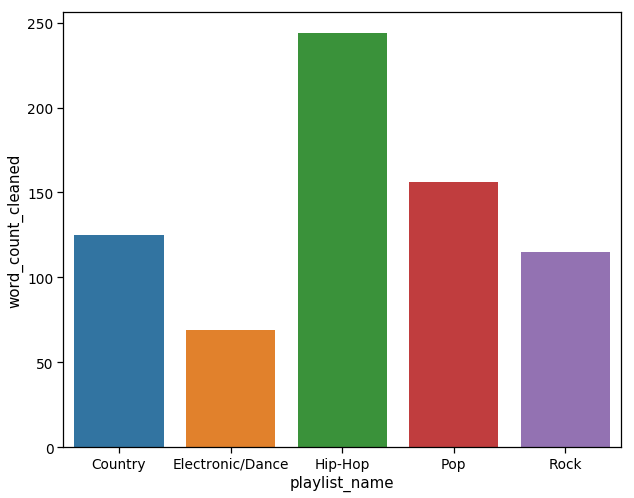

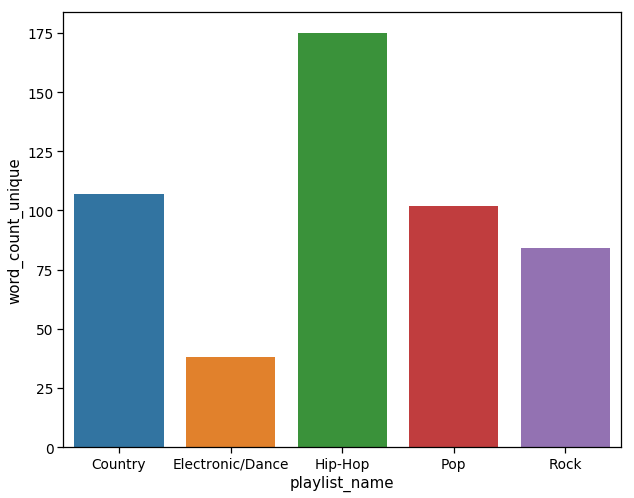

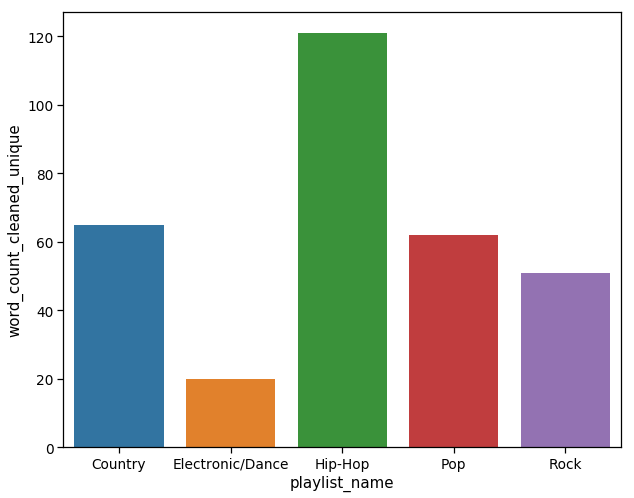

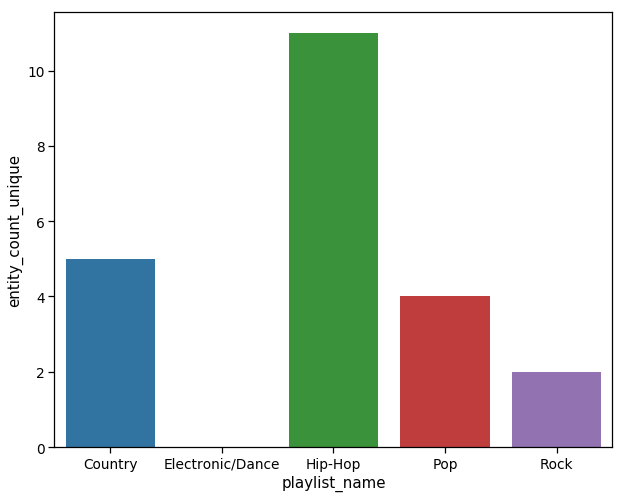

In [41]:
plt.rcParams['figure.figsize'] = [10, 8]
for feature in numerical_variables:
    sns.barplot(data=spotify_df_agg, x='playlist_name', y=feature)
    plt.show()

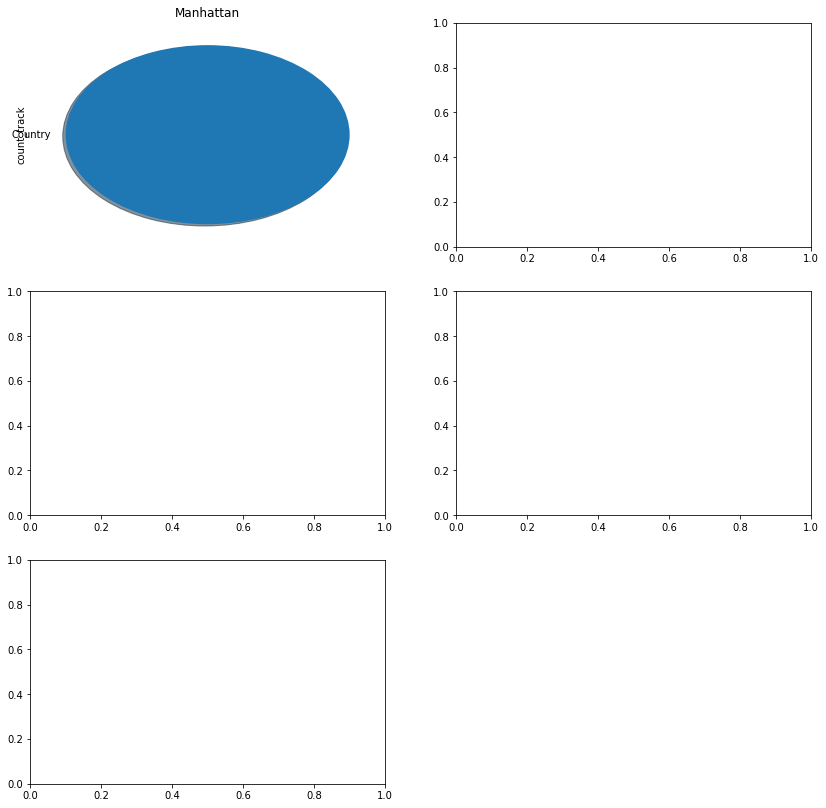

In [84]:
#Plot pie charts of Race across borough
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.delaxes(axes[2,1])

spotify_df_agg[spotify_df_agg['playlist_name'] == 'Rock'].plot(ax=axes[0,0], kind='pie', \
                                labels=spotify_df_agg['playlist_name'], y='count_track', \
                                figsize=[14, 14], title='Manhattan', legend=False, shadow=True)
#race_df[race_df['playlist_name'] == 'Queens'].plot(ax=axes[0,1], kind='pie', labels=race_df['Race'], y='Percentage', figsize=[14, 14], title='Queens', legend=False, shadow=True)
#race_df[race_df['Zone'] == 'Brooklyn'].plot(ax=axes[1,0], kind='pie', labels=race_df['Race'], y='Percentage', figsize=[14, 14], title='Brooklyn', legend=False, shadow=True)
#race_df[race_df['Zone'] == 'Staten Island'].plot(ax=axes[1,1], kind='pie', labels=race_df['Race'], y='Percentage', figsize=[14, 14], title='Staten Island', legend=False, shadow=True)
#race_df[race_df['Zone'] == 'Bronx'].plot(ax=axes[2,0], kind='pie', labels=race_df['Race'], y='Percentage', figsize=[14, 14], title='Bronx', legend=False, shadow=True)
plt.show()

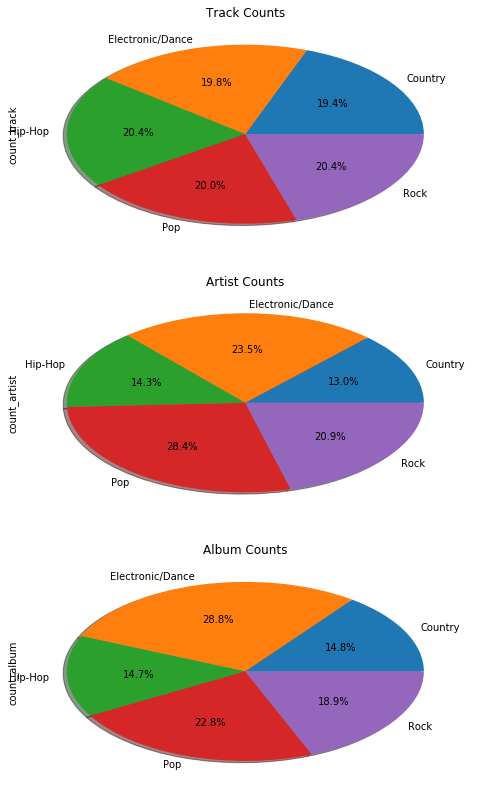

In [109]:
#Plot pie charts of Race across borough
fig, axes = plt.subplots(nrows=3, ncols=1)
#fig.delaxes(axes[3,1])

spotify_df_agg.plot(ax=axes[0], kind='pie', y='count_track', figsize=[8, 14], autopct='%1.1f%%', \
                    labels=spotify_df_agg['playlist_name'], title='Track Counts', legend=False, shadow=True, )

spotify_df_agg.plot(ax=axes[1], kind='pie', y='count_artist', figsize=[8, 14], autopct='%1.1f%%', \
                    labels=spotify_df_agg['playlist_name'], title='Artist Counts', legend=False, shadow=True)

spotify_df_agg.plot(ax=axes[2], kind='pie', y='count_album', figsize=[8, 14], autopct='%1.1f%%', \
                    labels=spotify_df_agg['playlist_name'], title='Album Counts', legend=False, shadow=True)

plt.show()

In [120]:
type(spotify_df['playlist_name'][0]), type(spotify_df['danceability'][0])

(str, numpy.float64)

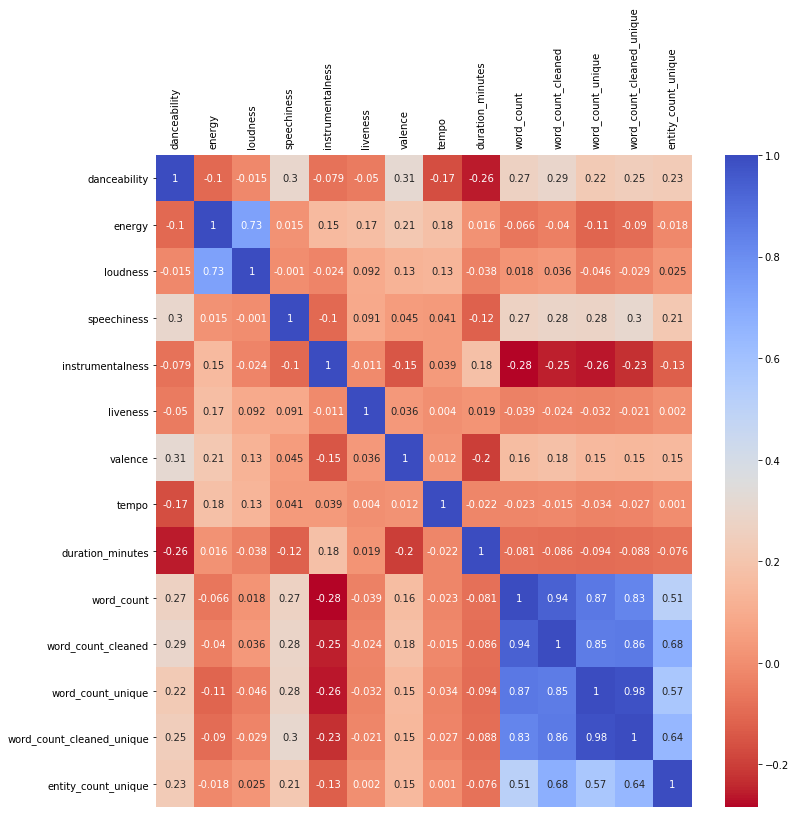

In [126]:
#Correlation Matrix including Y-variables (rates) 
corr = spotify_df[numerical_variables].corr().round(3)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
sns.heatmap(corr, annot=True, cmap='coolwarm_r')
plt.tick_params(labeltop=True, labelbottom=False, bottom=False)
plt.xticks(rotation=90)
plt.show()

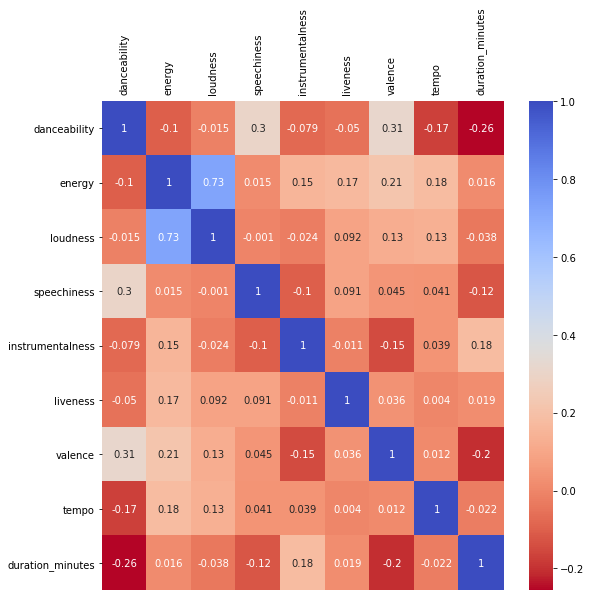

In [133]:
#Correlation Matrix including Y-variables (rates) 
corr = spotify_df[numerical_variables[:9]].corr().round(3)
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111)
sns.heatmap(corr, annot=True, cmap='coolwarm_r')
plt.tick_params(labeltop=True, labelbottom=False, bottom=False)
plt.xticks(rotation=90)
plt.show()

In [225]:
','.join(list((spotify_df[(~spotify_df['lyrics'].isnull()) & (spotify_df['playlist_name'] \
                                                        == 'Rock')]['lyrics'].head(1).values)))

"   gettin' born in the state of mississippi poppa was a copper and her momma was a hippie in alabama she would swing a hammer price you gotta pay when you break the panorama she never knew that there was anything more than poor what in the world what does your company take me for black bandana sweet louisiana robbin' on a bank in the state of indiana she's a runner rebel and a stunner on her merry way sayin' baby what you gonna— lookin' down the barrel of a hot metal 45 just another way to survive   california rest in peace simultaneous release california show your teeth she's my priestess i'm your priest yeah yeah   she's a lover baby and a fighter shoulda seen her comin' when it got a little brighter with a name like dani california day was gonna come when i was gonna mourn ya a little loaded she was stealin' another breath i love my baby to death   california rest in peace simultaneous release california show your teeth she's my priestess i'm your priest yeah yeah   who knew the ot

In [243]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [3]:
# Join the different processed titles together.
rock_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['playlist_name'] \
                                                                            == 'Rock')]['lyrics_cleaned_str'].values)))
country_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['playlist_name'] \
                                                                            == 'Country')]['lyrics_cleaned_str'].values)))
pop_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['playlist_name'] \
                                                                            == 'Pop')]['lyrics_cleaned_str'].values)))
hiphop_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['playlist_name'] \
                                                                            == 'Hip-Hop')]['lyrics_cleaned_str'].values)))
edm_cloud = ','.join(list((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull()) & (spotify_df['playlist_name'] \
                                                                            == 'Electronic/Dance')]['lyrics_cleaned_str'].values)))

genre_clouds = [rock_cloud, country_cloud, pop_cloud, hiphop_cloud, edm_cloud]


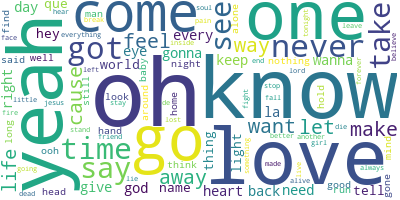

In [6]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3, contour_color='steelblue', collocations=False)

# Generate a word cloud
wordcloud.generate(rock_cloud)

# Visualize the word cloud
wordcloud.to_image()

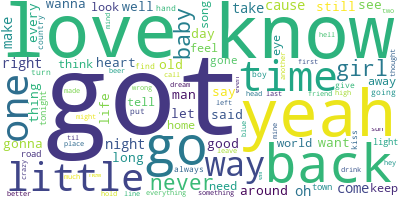

In [7]:
# Generate a word cloud
wordcloud.generate(country_cloud)

# Visualize the word cloud
wordcloud.to_image()

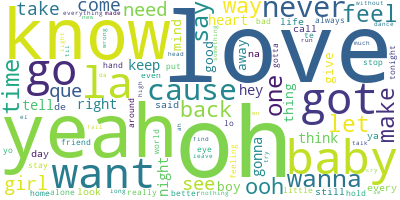

In [9]:
# Generate a word cloud
wordcloud.generate(pop_cloud)

# Visualize the word cloud
wordcloud.to_image()

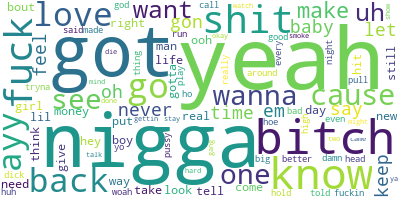

In [10]:
# Generate a word cloud
wordcloud.generate(hiphop_cloud)

# Visualize the word cloud
wordcloud.to_image()

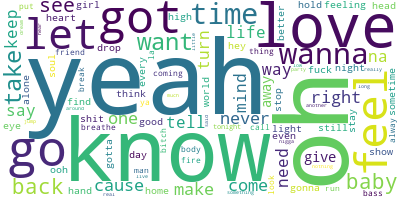

In [11]:
# Generate a word cloud
wordcloud.generate(edm_cloud)

# Visualize the word cloud
wordcloud.to_image()

In [4]:
# Helper function
def plot_10_most_common_words(count_data, vectorizer, title_name):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 10/1.6180))
    plt.subplot(title=title_name)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [15]:
spotify_df[spotify_df['playlist_name'] == 'Rock'].lyrics_cleaned_str

0       gettin born state mississippi poppa copper mom...
1       psychic spy china try steal elation little gir...
2       keep dark know pretend keep dark began send sk...
3       load gun bring friend fun lose pretend oh know...
4       scar tissue wish saw sarcastic mister close ey...
                              ...                        
1995    daydreaming night falling felt finger touch sk...
1996    think thing still hold thought someone else kn...
1997    cruising hyundai elantra looking mantra umm go...
1998    said loved threw garbage starting stink everyo...
1999    街は眠れど 建物はずっと建設中さ 都市計画遂行中 噛み合う蛇 モーフィングした環状線 エンド...
Name: lyrics_cleaned_str, Length: 2000, dtype: object

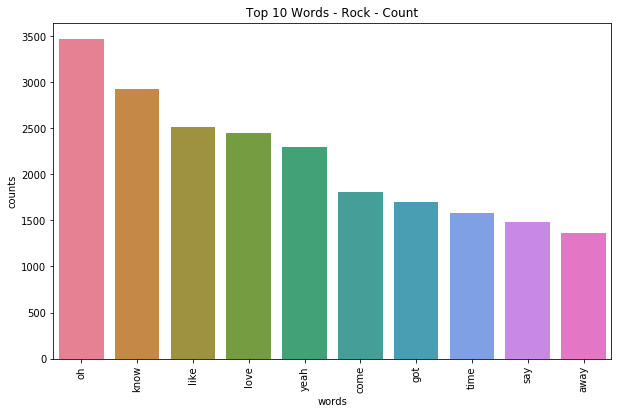

In [7]:
# Fit and transform the processed titles
count_rock = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Rock')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_rock, count_vectorizer, 'Top 10 Words - Rock - Count')

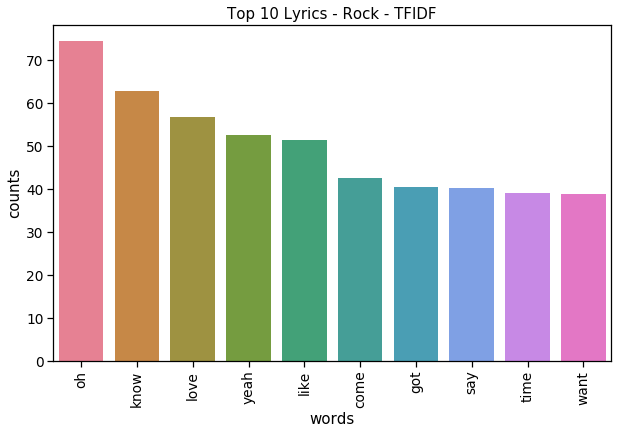

In [8]:
# Fit and transform the processed titles
tfidf_rock = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Rock')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_rock, tfidf_vectorizer, 'Top 10 Lyrics - Rock - TFIDF')

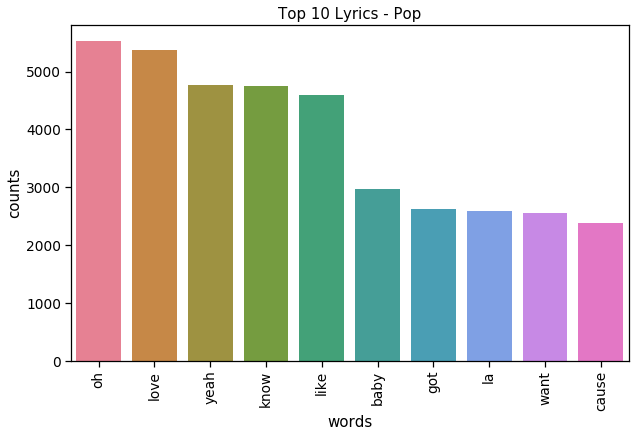

In [9]:
# Fit and transform the processed titles
count_pop = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Pop')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_pop, count_vectorizer, 'Top 10 Lyrics - Pop')

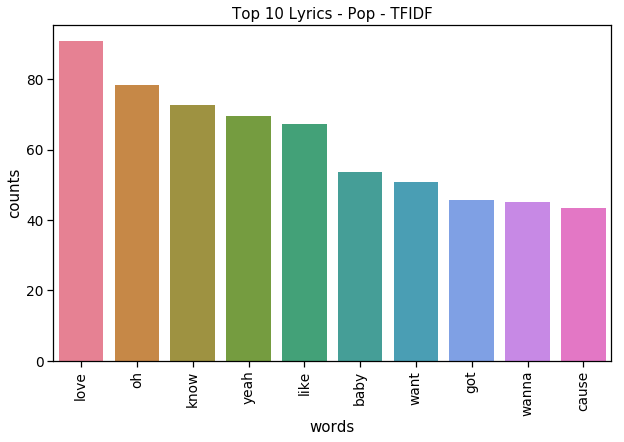

In [10]:
# Fit and transform the processed titles
tfidf_pop = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Pop')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_pop, tfidf_vectorizer, 'Top 10 Lyrics - Pop - TFIDF')

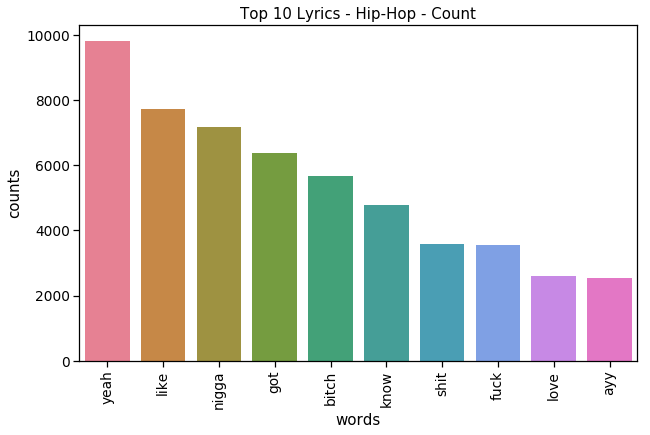

In [11]:
# Fit and transform the processed titles
count_hiphop = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Hip-Hop')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_hiphop, count_vectorizer, 'Top 10 Lyrics - Hip-Hop - Count')

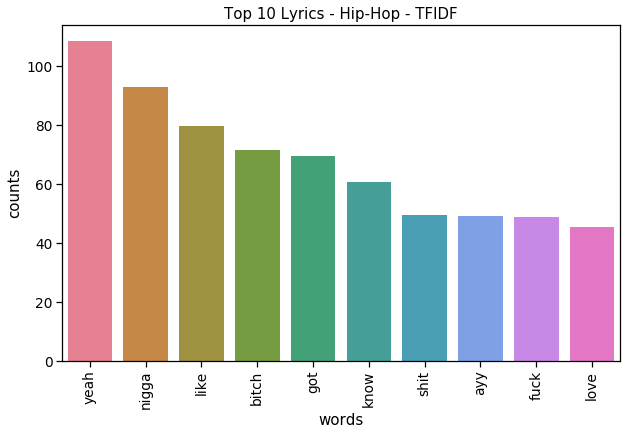

In [12]:
# Fit and transform the processed titles
tfidf_hiphop = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Hip-Hop')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_hiphop, tfidf_vectorizer, 'Top 10 Lyrics - Hip-Hop - TFIDF')

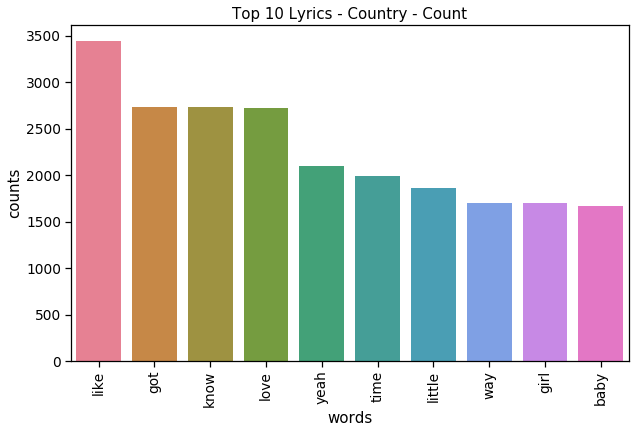

In [13]:
# Fit and transform the processed titles
count_country = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Country')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_country, count_vectorizer, 'Top 10 Lyrics - Country - Count')

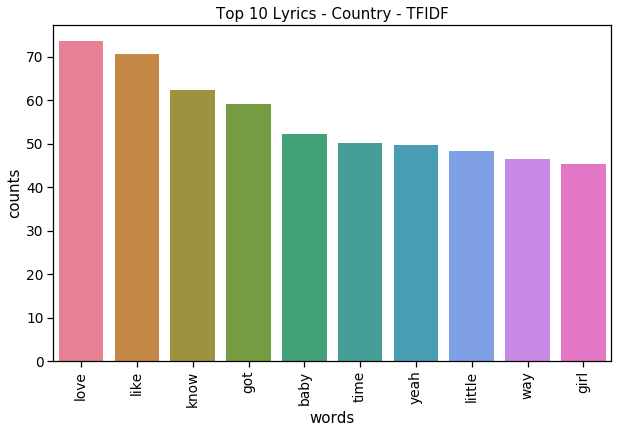

In [14]:
tfidf_country = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Country')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_country, tfidf_vectorizer, 'Top 10 Lyrics - Country - TFIDF')

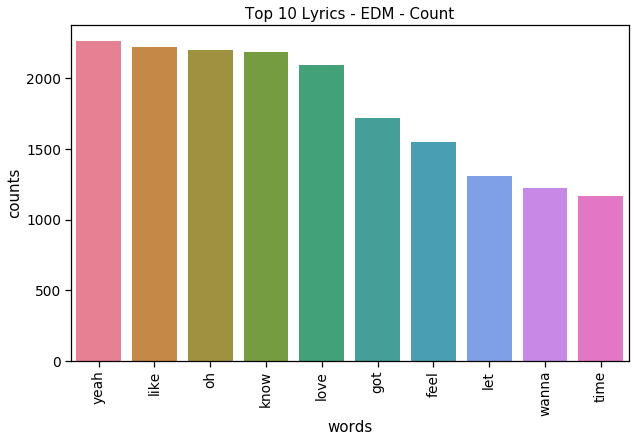

In [15]:
# Fit and transform the processed titles
count_edm = count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Electronic/Dance')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(count_edm, count_vectorizer, 'Top 10 Lyrics - EDM - Count')

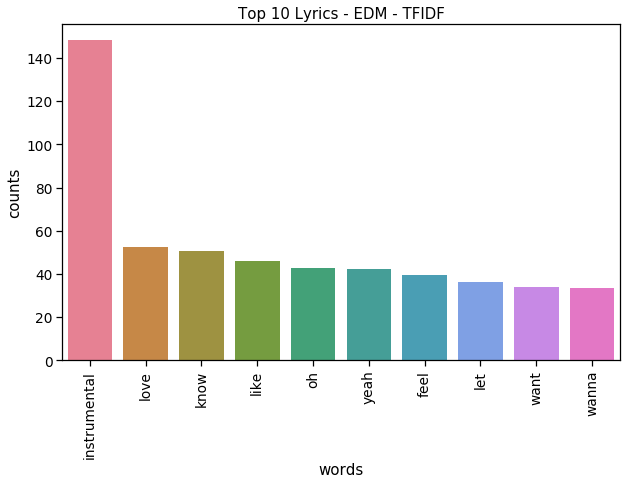

In [16]:
tfidf_edm = tfidf_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Electronic/Dance')].lyrics_cleaned_str))

# Visualise the 10 most common words
plot_10_most_common_words(tfidf_edm, tfidf_vectorizer, 'Top 10 Lyrics - EDM - TFIDF')

In [17]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Helper function
def print_topics(model, vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [63]:
# Create and fit the LDA model
count_total = count_vectorizer.fit_transform(spotify_df[~spotify_df['lyrics_cleaned_str'].isnull()].lyrics_cleaned_str)
count_vectorizer.fit_transform(spotify_df[~spotify_df['lyrics_cleaned_str'].isnull()].lyrics_cleaned_str)
lda_total = LDA(n_components=10)
lda_total.fit(count_total)


# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_total, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
like yeah know got bitch girl want time say right

Topic #1:
la lord song sing light jesus gimme soul city holy

Topic #2:
ooh yeah uh na baby ah turn nah woo gang

Topic #3:
god come shake stand save fight ready power breathe life

Topic #4:
feat boom drip dem lil beep gucci mr rose sauce

Topic #5:
love oh know feel let way like heart away cause

Topic #6:
yeah hey sunday oh hoo blah rhythm ey wa baar

Topic #7:
gon yo da body yuh wet water trick walk doh

Topic #8:
nigga fuck shit got like ayy money em hit lil

Topic #9:
que la te el en yo mi lo se tu


In [18]:
# Create and fit the LDA model
count_total = count_vectorizer.fit_transform(spotify_df[~spotify_df['lyrics_cleaned_str'].isnull()].lyrics_cleaned_str)
lda_total = LDA(n_components=5)
lda_total.fit(count_total)


# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_total, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
oh god come life let heart light lord world soul

Topic #1:
na yeah hey bomb dum drop halo wub не blah

Topic #2:
yeah nigga bitch like got fuck shit ayy uh gon

Topic #3:
know love like yeah got time baby cause want wanna

Topic #4:
la que da te el en yo mi lo se


In [19]:
# Create and fit the LDA model
lda_rock = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Rock')].lyrics_cleaned_str))
lda_rock.fit(count_rock)


# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_rock, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
yeah oh like got know gonna time wanna feel make

Topic #1:
love oh know say way feel like need away time

Topic #2:
la que te el mi en tu nah ah yo

Topic #3:
god heart come let jesus love lord life holy oh

Topic #4:
na ich 限りなく黒に近いグレイ ああ pa du 聖者たち feat きみが欲しいのさ まだ空っぽな明日は


In [20]:
# Create and fit the LDA model
lda_pop = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Pop')].lyrics_cleaned_str))
lda_pop.fit(count_pop)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_pop, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
yeah oh ich love na du sie baby need 내가

Topic #1:
love oh know like yeah baby got want cause wanna

Topic #2:
la que te en el qué na mi yo se

Topic #3:
da ba feat dee dye blue bum halo lil ayy

Topic #4:
come shake ah girl bitch oh doh hey pop jesus


In [21]:
# Create and fit the LDA model
lda_hiphop = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Hip-Hop')].lyrics_cleaned_str))
lda_hiphop.fit(count_hiphop)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_hiphop, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
la movin que el ey bam mi forward tú en

Topic #1:
woah na feat loner woop king lil black da la

Topic #2:
la не bir меня на что мне ты da как

Topic #3:
like know got nigga yeah love shit cause fuck time

Topic #4:
yeah bitch nigga like got ayy fuck shit uh ooh


In [22]:
# Create and fit the LDA model
lda_country = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Country')].lyrics_cleaned_str))
lda_country.fit(count_country)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_country, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
country got yeah song little girl boy like said come

Topic #1:
love know like got baby time way yeah girl make

Topic #2:
feat drinkin chain smokin quit el choo lost famous la

Topic #3:
got little old big town cowboy like na texas man

Topic #4:
like night blue yeah time la going oh old got


In [23]:
# Create and fit the LDA model
lda_edm = LDA(n_components=5)
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Electronic/Dance')].lyrics_cleaned_str))
lda_edm.fit(count_edm)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_edm, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
la bass breathe boom beep dun hum nyu blah cannon

Topic #1:
yeah drop dem city light man run away ha dum

Topic #2:
got love like want turn fuck come hey know let

Topic #3:
na low feat untz wub instrumental dub baar push song

Topic #4:
oh know feel like wanna time baby right let love


In [30]:
import pyLDAvis.gensim as pylda
#pyLDAvis.enable_notebook()
count_vectorizer.fit_transform((spotify_df[(~spotify_df['lyrics_cleaned_str'].isnull())
                                    & (spotify_df['playlist_name']  == 'Rock')].lyrics_cleaned_str))
py_rock = sklearn_lda.prepare(lda_rock, count_rock, count_vectorizer)
py_rock

NameError: name 'sklearn_lda' is not defined